In [1]:
import shuffles
import numpy as np
import matplotlib.pyplot as plt
from deck import Deck
import seaborn as sns
from sklearn.metrics import mutual_info_score

## What is this code for
Basically this code is a small bit of analysis of some simulated shuffling of cards.
It's to look at patterns created when a deck of cards is shuffled from a known state and ultimately if this information can be exploited.
The shuffles used are in the shuffles.py file and can be added to and most of the shuffles have parameters that can be tuned to try and match the real world.

In [2]:
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Card Position Correlation Matrix")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()
    
def plot_transition_matrix(transition_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_matrix, cmap='coolwarm', center=0)
    plt.title("Card Position Transition Matrix")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()

def plot_conditional_probabilities(probs, card1, card2):
    plt.figure(figsize=(6, 5))
    plt.imshow(probs, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"P(Card {card2} position | Card {card1} position)")
    plt.xlabel(f"Position of Card {card2}")
    plt.ylabel(f"Position of Card {card1}")
    plt.show()

def plot_mutual_information_matrix(mi_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(mi_matrix, cmap='viridis')
    plt.title("Mutual Information between Card Positions")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()
    
def plot_average_displacement(avg_displacement):
    plt.figure(figsize=(6, 3))
    plt.plot(avg_displacement)
    plt.title("Average Displacement of Cards After Shuffling")
    plt.xlabel("Original Card Position")
    plt.ylabel("Average Displacement")
    plt.show()

def plot_position_entropy(entropies):
    plt.figure(figsize=(6, 3))
    plt.plot(entropies)
    plt.title("Entropy of Card Positions After Shuffling")
    plt.xlabel("Card ID")
    plt.ylabel("Entropy (bits)")
    plt.show()
    

def plot_all_graphs(correlation_matrix, transition_matrix, mi_matrix, avg_displacement, entropies, cond_probs, card1, card2):
    fig, axs = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("Card Shuffling Analysis", fontsize=16)

    # Correlation Matrix
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[0, 0])
    axs[0, 0].set_title("Card Position Correlation Matrix")
    axs[0, 0].set_xlabel("Card ID")
    axs[0, 0].set_ylabel("Card ID")

    # Transition Matrix
    sns.heatmap(transition_matrix, cmap='coolwarm', center=0, ax=axs[0, 1])
    axs[0, 1].set_title("Card Position Transition Matrix")
    axs[0, 1].set_xlabel("Card ID")
    axs[0, 1].set_ylabel("Card ID")

    # Average Displacement
    axs[1, 0].plot(avg_displacement)
    axs[1, 0].set_title("Average Displacement of Cards After Shuffling")
    axs[1, 0].set_xlabel("Original Card Position")
    axs[1, 0].set_ylabel("Average Displacement")

    # Conditional Probability
    im = axs[1, 1].imshow(cond_probs, aspect='auto', cmap='viridis')
    axs[1, 1].set_title(f"P(Card {card2} position | Card {card1} position)")
    axs[1, 1].set_xlabel(f"Position of Card {card2}")
    axs[1, 1].set_ylabel(f"Position of Card {card1}")
    plt.colorbar(im, ax=axs[1, 1])

    plt.tight_layout()
    plt.show()

  

In [3]:
# analyses 1 shuffle
def analyse(cards, matrix, orders):
    
    for index, card in enumerate(cards.get()):
        matrix[int(card)][index] += 1
        
    orders.append([list(cards.get()).index(i) for i in range(cards.size)])


# analyses n repetitions of shuffle on a deck of chosen size    
def analyse_n(cards, n, shuffle):
    
    transition_matrix = np.zeros((cards.size, cards.size))
    mi_matrix = np.zeros((cards.size, cards.size))
    probs = np.zeros((cards.size, cards.size))
    e_probs = np.zeros((cards.size, cards.size))
    entropies = np.zeros(cards.size)
    card1 = 0
    card2 = 2
    results = []
    
    for i in range(n):
        cards.shuffle(shuffle)
        analyse(cards, transition_matrix, results)
        cards.reset()
    
    results = np.array(results)
    
    for i in range(cards.size):
        
        mask = results[:, card1] == i
        if np.sum(mask) > 0:
            probs[i] = np.bincount(results[mask, card2], minlength=cards.size) / np.sum(mask)
        
        e_probs = np.bincount(results[:, i], minlength=cards.size) / n
        entropies[i] = -np.sum(e_probs * np.log2(probs + 1e-10))
        
        for j in range(i, cards.size):
            mi = mutual_info_score(results[:, i], results[:, j])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi    
    
    displacements = np.abs(results - np.arange(cards.size))
    avg_displacement = np.mean(displacements, axis=0)
    coefficient = np.corrcoef(np.array(results).T)
    transition_matrix = transition_matrix/n
    
    plot_all_graphs(coefficient, transition_matrix, mi_matrix, avg_displacement, entropies, probs, card1, card2)

In [4]:
# global parameters for now as still figuring out how to go about creating personal shuffles
PORTION = 0.5
STDEV = 0.05
STICKINESS = 0.25

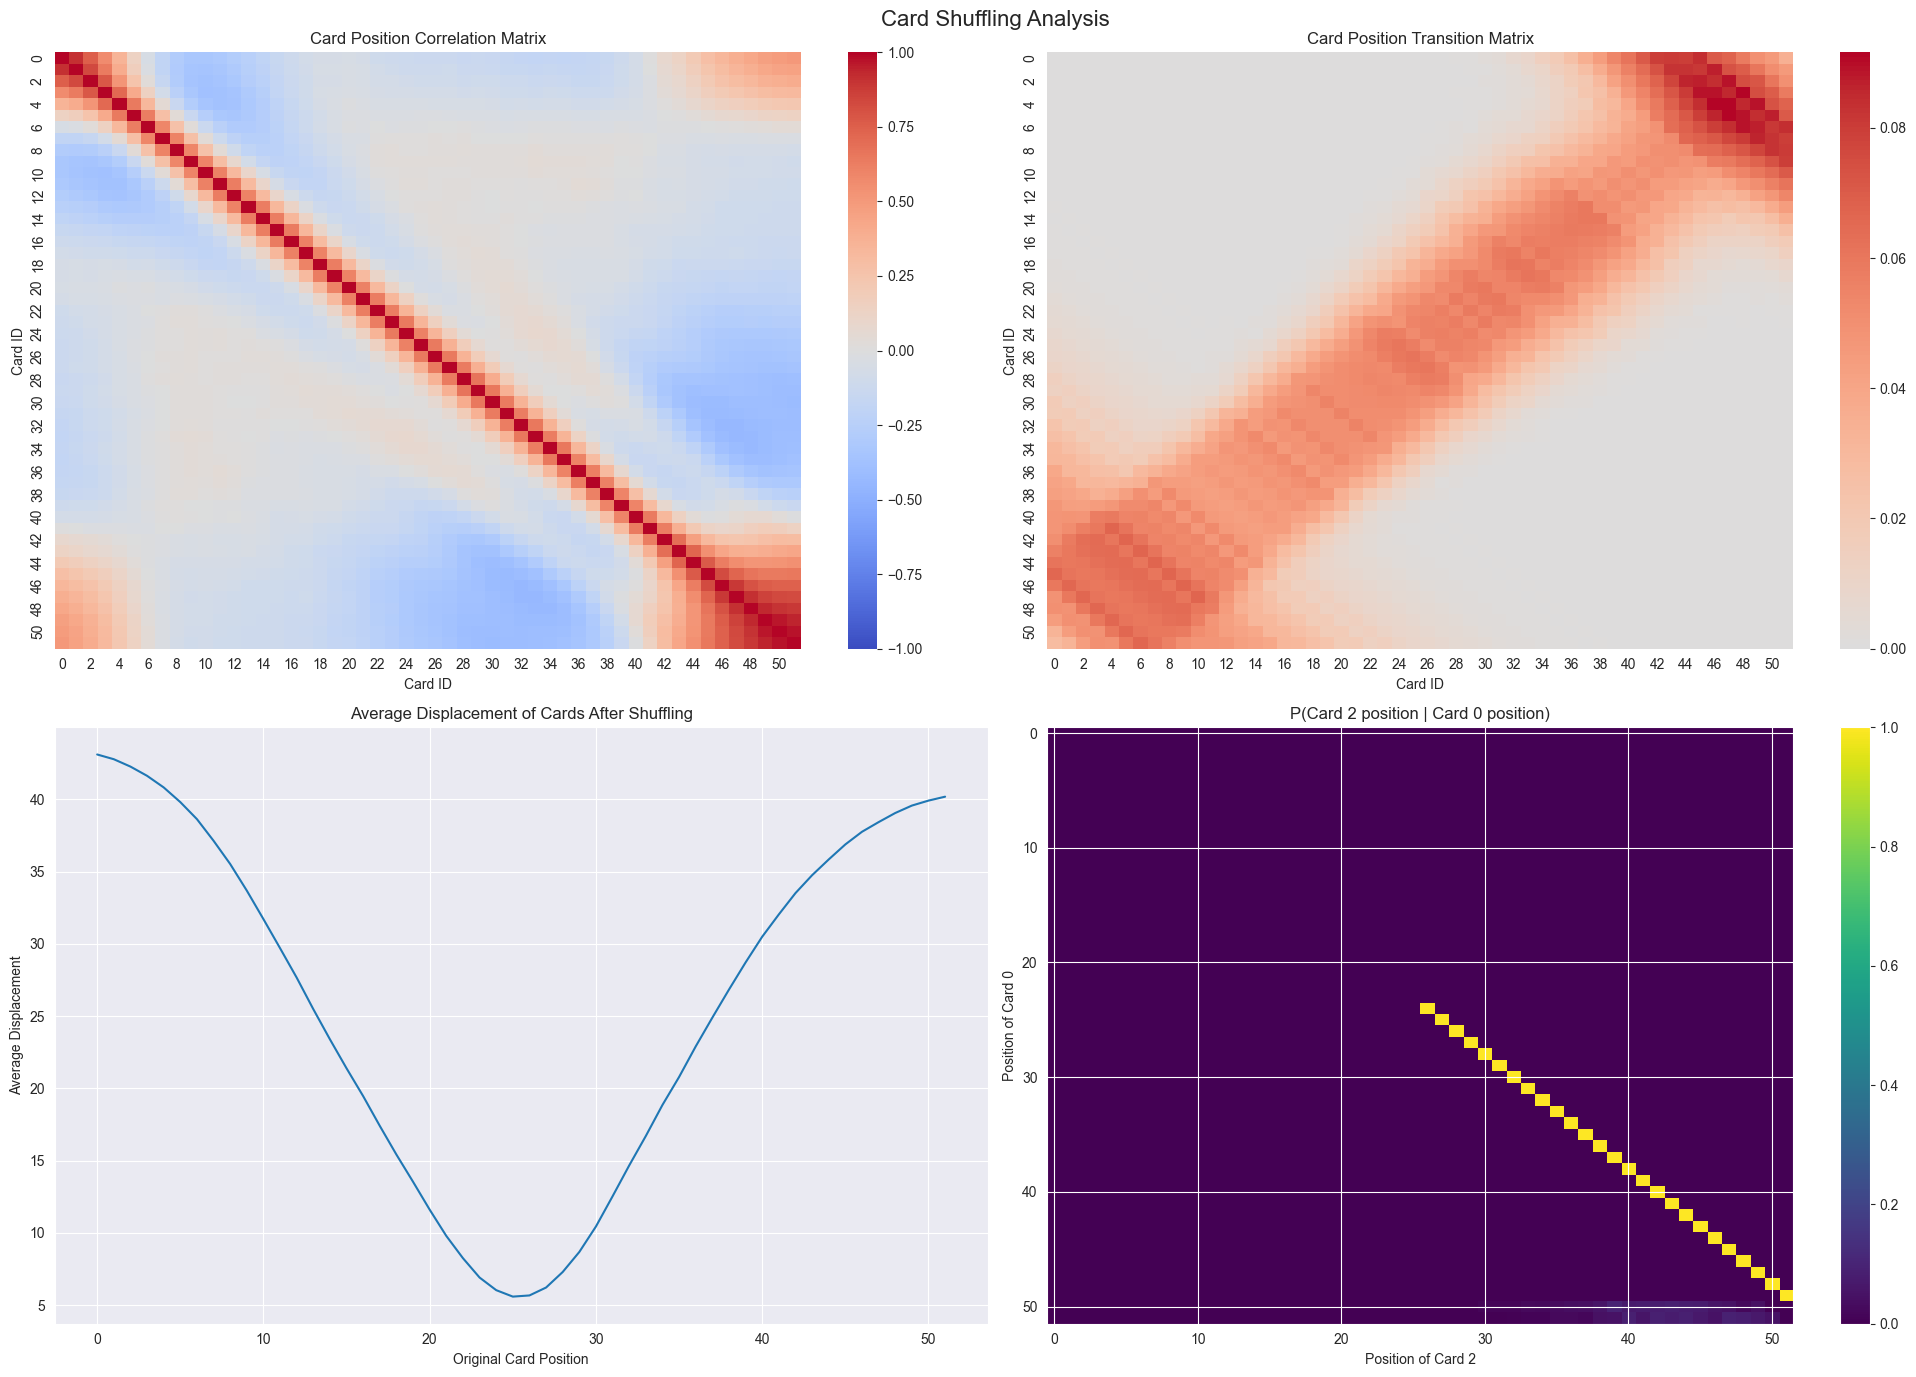

In [5]:
# cut-riffle
def riffle_shuffle(deck):
    a, b = shuffles.cut(deck, PORTION, STDEV)
    deck = shuffles.riffle(a, b, STICKINESS)
    return deck

def box(d):
    d = shuffles.box(d, 6, 0.1)
    return d
        
deck = Deck(52)

analyse_n(deck, 10000, [box])

In [28]:
analyse_n(deck, 1000000, [riffle_shuffle, box, riffle_shuffle, box, riffle_shuffle, box, riffle_shuffle])

KeyboardInterrupt: 

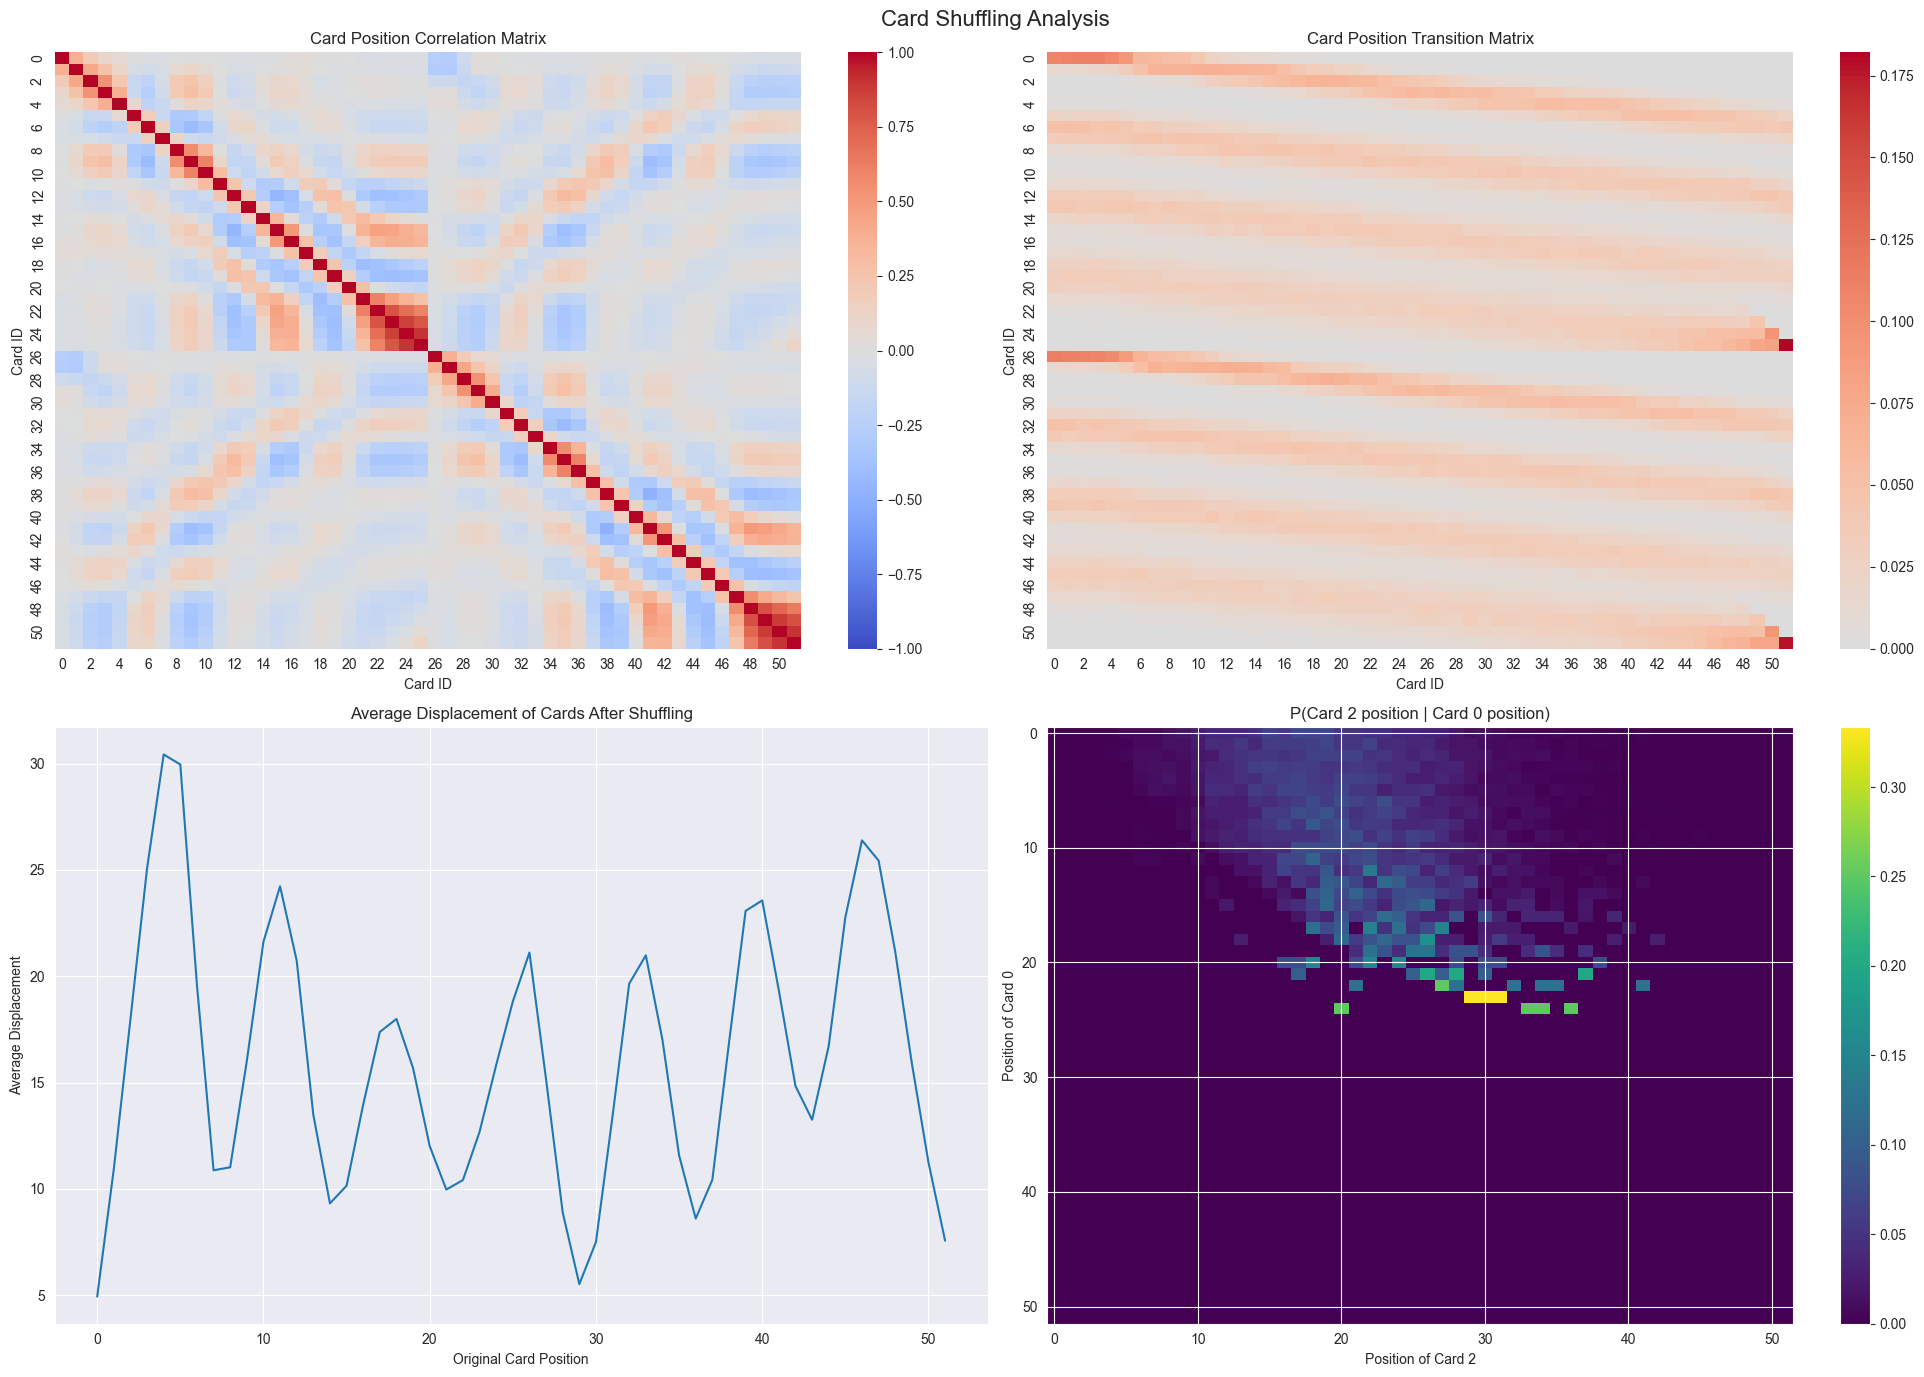

In [8]:
d8 = Deck(52)
a = d8.get()
d = shuffles.custom(a)
analyse_n(d8, 10000, [shuffles.custom])

In [6]:
from scipy import stats
from tqdm import tqdm
def compute_significant_pairwise_conditional_probabilities(shuffles, num_cards):
    """
    Compute pairwise conditional probabilities for all pairs of cards,
    storing only those that show a significant relationship.
    
    Parameters:
    shuffles (np.array): A 2D array where each row represents a shuffle,
                         and each column represents the final position of a card.
    num_cards (int): The total number of cards in the deck.
    
    Returns:
    dict: A dictionary where keys are tuples (i, j) representing card pairs,
          and values are 2D arrays representing significant conditional probabilities.
    """
    significant_probs = {}
    total_pairs = num_cards * (num_cards - 1)
     
    with tqdm(total=total_pairs, desc="Computing probabilities") as pbar:
        for i in range(num_cards):  # First card (condition)
            for j in range(num_cards):  # Second card (target)
                if i != j:  # We don't compute probabilities for the same card
                    probs = np.zeros((num_cards,num_cards))
                    
                    for k in range(num_cards):  # Position of first card
        
                        mask = shuffles[:, i] == k
                        if np.sum(mask) > 0:
                            probs[k] = np.bincount(shuffles[mask, j], minlength=num_cards) / np.sum(mask)
 
                    
                    significant_probs[(i, j)] = probs
                    
                    pbar.update(1)
        
    return significant_probs

# Example usage
num_cards = 52
num_shuffles = 10000

def gen(n):
    results = []
    cards = Deck(52)
    for i in range(n):
        cards.shuffle([box])
        results.append([list(cards.get()).index(i) for i in range(cards.size)])
        cards.reset()
    
    return np.array(results)

shuffles = gen(10000)

# Compute significant pairwise conditional probabilities
significant_probs = compute_significant_pairwise_conditional_probabilities(shuffles, num_cards)





Computing probabilities: 100%|██████████| 2652/2652 [00:05<00:00, 495.96it/s]

Number of significant card pair relationships: 2652
There is a significant relationship between cards 0 and 1
Probability distribution:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.04100946 0.03470032 0.        ]]


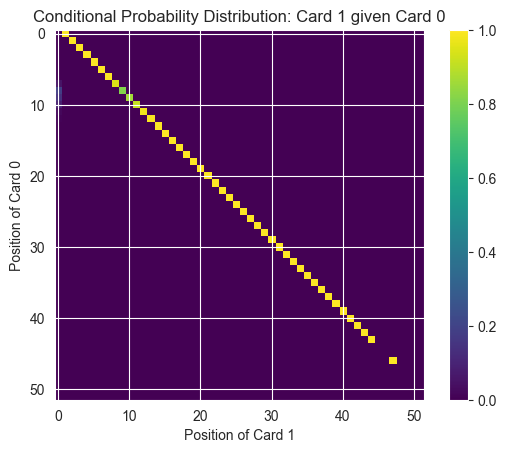

In [7]:
c1 = 0
c2 = 1
plt.imshow(significant_probs[(c1, c2)], cmap='viridis', interpolation='nearest')
plt.title("Conditional Probability Distribution: Card 1 given Card 0")
plt.xlabel(f"Position of Card {c1}")
plt.ylabel(f"Position of Card {c2}")
plt.colorbar()
plt.show()
     
